In [1]:
from comet_ml import Experiment

import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa # audio analysis
import librosa.display # this submodule needs to be imported explicitly
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import os

In [2]:
import IPython.display as ipd
import wave

In [3]:
timing = pd.read_csv('../csvFiles/set_a_timing.csv')

In [4]:
S1 = dict()
S2 = dict()
noise_1 = dict()
noise_2 = dict()

file_name = list(timing['fname'].unique())

for i in file_name:
    S1[i] = []
    S2[i] = []
    noise_1[i] = []
    noise_2[i] = []

for i in range(len(timing)):
    if timing.sound[i] == 'S1':
        S1[timing.fname[i]].append(timing.loc[i,'location']-1000)
        noise_1[timing.fname[i]].append(timing.loc[i,'location']+2000) # add the noise location after S1 sound
        # S1 sounds have duration between 4000-5000 frames
    else:
        S2[timing.fname[i]].append(timing.loc[i,'location']-1000)
        noise_2[timing.fname[i]].append(timing.loc[i,'location']+2500)

In [5]:
def frames_to_TC_ms (frames):
    h = int(frames / 158760000) # 60*60*44100
    m = int(frames / 2646000) % 60  # 60*44100
    s = int((frames % 2646000)/44100)
    f = frames % 2646000 % 44100
    return s*1000

In [6]:
from datetime import timedelta

FPS = 44100
frame_count = 347886
td = timedelta(seconds=(frame_count / FPS))
print(str(td)[6:])

7.888571


In [7]:
from pydub import AudioSegment

/home/chico/Desktop/taad/projeto/taad-project/env/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [8]:
new = timing.copy()
original_size = len(new.index)
new['time']=(new.location-1000)*1000/44100
for i in range(len(timing)):
    if timing.sound[i] == 'S1':
        nameCut = timing.fname[i]
        nameCut = nameCut[5:26]
        cycle = new.iloc[i]['cycle']
        newName = '../set_a_cut' + nameCut + '_S1_' + str(cycle) + '.wav' # defines new name
        s = new.iloc[i]['sound']
        location = new.iloc[i]['location']-1000
        time = new.iloc[i]['time']
        new.loc[i] = [newName, cycle, s, location, time] # creates new row with the new name
    if timing.sound[i] == 'S2':
        nameCut = timing.fname[i]
        nameCut = nameCut[5:26]
        cycle = new.iloc[i]['cycle']
        newName = '../set_a_cut' + nameCut + '_S2_' + str(cycle) + '.wav'
        s = new.iloc[i]['sound']
        location = new.iloc[i]['location']-1000
        time = new.iloc[i]['time']
        new.loc[i] = [newName, cycle, s, location, time]
i = 389
for k in range(len(timing)):
    nameCut = timing.fname[k]
    nameCut = nameCut[5:26]
    cycle = new.iloc[k]['cycle']
    s = new.iloc[k]['sound']
    newSound = 'noise'+s
    if str(cycle)=='1' and str(s)=='S1':
        newLocation = 0
        time = 0
        cycle = 0
        newName = '../set_a_cut' + nameCut + '_noise' + str(s) +'_0' + '.wav'
        i += 1
        new.loc[i] = [newName, cycle, newSound, newLocation, time]
    cycle = new.iloc[k]['cycle']
    s = new.iloc[k]['sound']
    newName = '../set_a_cut' + nameCut + '_noise' + str(s) +'_'+ str(cycle) + '.wav'
    location = new.iloc[k]['location']
    if str(s)=='S1':
        newLocation = location+3000
    if str(s)=='S2':
        newLocation = location+3500
    time = (newLocation)*1000/44100
    i += 1
    new.loc[i] = [newName, cycle, newSound, newLocation, time]
    
print(new)
new.to_csv('../csvFiles/newTiming.csv')

                                                fname  cycle    sound  \
0          ../set_a_cut/normal__201102081321_S1_1.wav      1       S1   
1          ../set_a_cut/normal__201102081321_S2_1.wav      1       S2   
2          ../set_a_cut/normal__201102081321_S1_2.wav      2       S1   
3          ../set_a_cut/normal__201102081321_S2_2.wav      2       S2   
4          ../set_a_cut/normal__201102081321_S1_3.wav      3       S1   
..                                                ...    ...      ...   
796  ../set_a_cut/normal__201108011118_noiseS2_10.wav     10  noiseS2   
797  ../set_a_cut/normal__201108011118_noiseS1_11.wav     11  noiseS1   
798  ../set_a_cut/normal__201108011118_noiseS2_11.wav     11  noiseS2   
799  ../set_a_cut/normal__201108011118_noiseS1_12.wav     12  noiseS1   
800  ../set_a_cut/normal__201108011118_noiseS2_12.wav     12  noiseS2   

     location         time  
0        9021   204.557823  
1       19759   448.049887  
2       34075   772.675737  
3      

In [11]:
# Audio cut of S1
FPS = 44100
for k in file_name:
    obj = wave.open('../'+k, mode='rb')
    td = timedelta(seconds=(obj.getnframes()/ FPS))
    a = str(td)[6:]
    # print(float(a)*1000) # total time
    for i in range(len(S1[k])):
        framesS1 = S1[k][i] # audio cut S1
        framesNoise = S1[k][i]+3500 # end of audio cut, considering a duration average of 4500 frames
        a = timedelta(seconds=(framesS1/ FPS)) # transforma em tempo, em segundos
        b = timedelta(seconds=(framesNoise/ FPS))
        t1_ = str(a)[6:] # cuts the time string
        t2_ = str(b)[6:]
        t1_ms = float(t1_)*1000 # turns string into float
        t2_ms = float(t2_)*1000
        new = new.assign(
            time = t1_ms)
        path = '../' + k
        newAudio = AudioSegment.from_wav(path)
        newAudio = newAudio[t1_ms:t2_ms] # cuts audios
        nameCut = k[5:26]
        newName = '../set_a_cut' + nameCut + '_S1_' + str(i+1) + '.wav'
        newAudio.export(newName, format = 'wav')

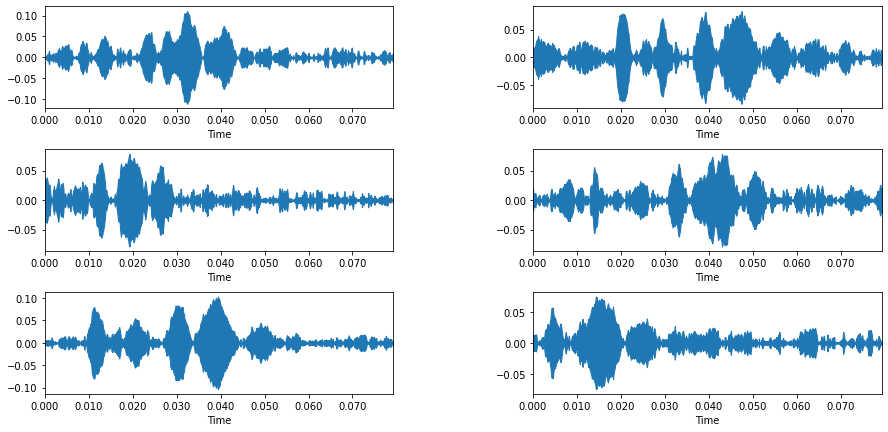

In [12]:
# plot waves of S1
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i in range(6):
    fig.add_subplot(6,2,1+i)
    name = '../set_a_cut/normal__201102081321_S1_'+str(i+1)+'.wav'
    data, sample_rate = librosa.load(name)
    librosa.display.waveplot(data, sr = sample_rate)

In [13]:
# S2 audiocut
FPS = 44100
for k in file_name:
    obj = wave.open('../'+k, mode='rb')
    td = timedelta(seconds=(obj.getnframes()/ FPS))
    a = str(td)[6:]
    for i in range(len(S2[k])):
        framesS2 = S2[k][i]
        framesNoise = S2[k][i]+3500
        a = timedelta(seconds=(framesS2/ FPS))
        b = timedelta(seconds=(framesNoise/ FPS))
        t1_ = str(a)[6:]
        t2_ = str(b)[6:]
        t1_ms = float(t1_)*1000
        t2_ms = float(t2_)*1000
        path = '../' + k
        newAudio = AudioSegment.from_wav(path)
        newAudio = newAudio[t1_ms:t2_ms]
        nameCut = k[5:26]
        newName = '../set_a_cut' + nameCut + '_S2_' + str(i+1) + '.wav'
        newAudio.export(newName, format = 'wav')

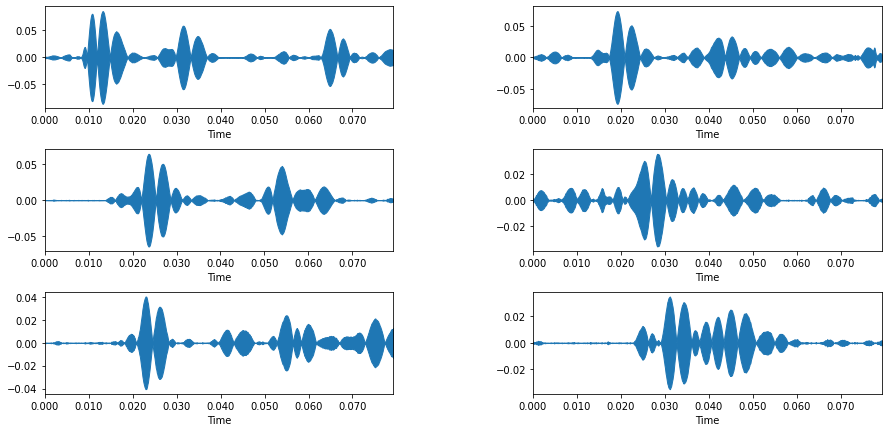

In [14]:
# plot waves of S2
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i in range(6):
    fig.add_subplot(6,2,i+1)
    name = '../set_a_cut/normal__201102260502_S2_'+str(i+1)+'.wav'
    data, sample_rate = librosa.load(name)
    librosa.display.waveplot(data, sr = sample_rate)

In [15]:
# noise cut
for k in file_name:
    obj = wave.open('../'+k, mode='rb')
    td = timedelta(seconds=(obj.getnframes()/ FPS))
    a = str(td)[6:]
    for i in range(len(noise_1[k])):
        framesNoise = noise_1[k][i] # beginning of noise cut
        framesS2 = S2[k][i] # end of noise (beginning of S2)
        a = timedelta(seconds=(framesNoise/ FPS)) # turns frames into time, in seconds
        b = timedelta(seconds=(framesS2/ FPS))
        t1_ = str(a)[6:] 
        t2_ = str(b)[6:]
        t1_ms = float(t1_)*1000 
        t2_ms = float(t2_)*1000
        path = '../' + k
        if (t1_ms < t2_ms):
            newAudio = AudioSegment.from_wav(path)
            newAudio = newAudio[t1_ms:t2_ms]
            nameCut = k[5:26]
            newName = '../set_a_cut' + nameCut + '_noiseS1_' + str(i+1) + '.wav'
            newAudio.export(newName, format = 'wav')
        
for k in file_name:
    obj = wave.open('../'+k, mode='rb') # opens the file as an object in write mode: "rb"
    td = timedelta(seconds=(obj.getnframes()/ FPS)) # total time of the audio
    a = str(td)[6:]
    t_total = float(a)*1000 # total time in milliseconds
    for i in range(len(noise_2[k])):
        if i==0:
            framesNoise = 0 # takes the noise from the beginning of the audio
            framesS1 = S1[k][i] # cuts the audio (beginning of S1)
            b = timedelta(seconds=(framesS1/ FPS))
            t2_ = str(b)[6:]
            t1_ms = 0
            t2_ms = float(t2_)*1000
            path = '../' + k
            newAudio = AudioSegment.from_wav(path)
            newAudio = newAudio[t1_ms:t2_ms]
            nameCut = k[5:26]
            newName = '../set_a_cut' + nameCut + '_noiseS1_' + str(i) + '.wav'
            newAudio.export(newName, format = 'wav')

        elif i==(len(noise_2[k])-1):
            t2_ms = t_total # cut the audio untill the end
            framesNoise = noise_2[k][i] # starts the noise after the S2 sound
            a = timedelta(seconds=(framesNoise/ FPS)) 
            t1_ = str(a)[6:]
            t1_ms = float(t1_)*1000
        else:
            framesNoise = noise_2[k][i] # starts the noise after the S2 sound
            framesS1 = S1[k][i+1] # cut the end of the noise (beggining of S1)
            a = timedelta(seconds=(framesNoise/ FPS)) # turns the frame into time
            b = timedelta(seconds=(framesS1/ FPS))
            t1_ = str(a)[6:]
            t2_ = str(b)[6:]
            t1_ms = float(t1_)*1000 # turns the string back in float, in milliseconds
            t2_ms = float(t2_)*1000
        path = '../' + k
        if (t1_ms < t2_ms):
            newAudio = AudioSegment.from_wav(path)
            newAudio = newAudio[t1_ms:t2_ms] # cut audio
            nameCut = k[5:26]
            newName = '../set_a_cut' + nameCut + '_noiseS2_' + str(i+1) + '.wav'
            newAudio.export(newName, format = 'wav')
        else:
            print(k)

set_a/normal__201105011626.wav


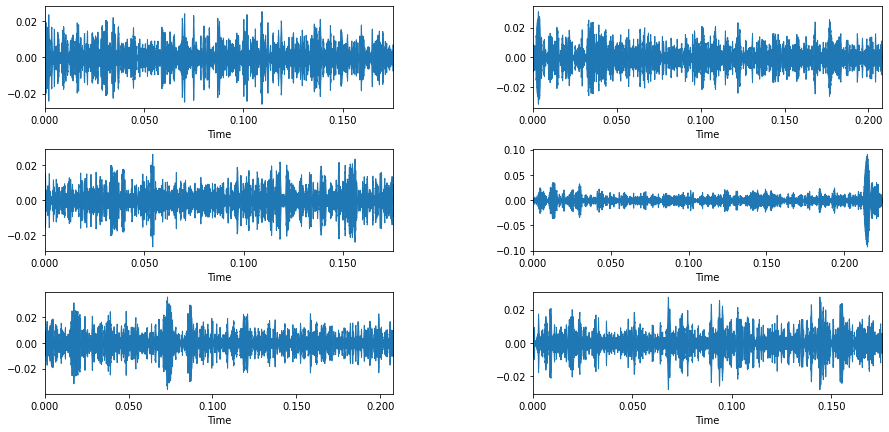

In [16]:
# plot of noise after S1 and before S2
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i in range(6):
    fig.add_subplot(6,2,1+i)
    name = '../set_a_cut/normal__201102081321_noiseS1_' + str(i+1) + '.wav'
    data, sample_rate = librosa.load(name)
    librosa.display.waveplot(data, sr = sample_rate)

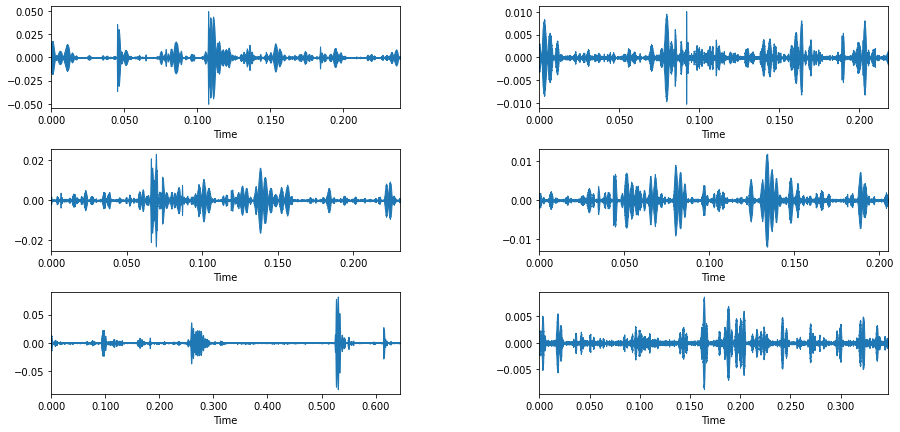

In [17]:
# plot of noise after S2 and before S1
# also considers the noise before the S1 starts at each audio and after S2 until the end of the audio
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i in range(6):
    fig.add_subplot(6,2,1+i)
    name = '../set_a_cut/normal__201102260502_noiseS2_' + str(i+1) + '.wav'
    data, sample_rate = librosa.load(name)
    librosa.display.waveplot(data, sr = sample_rate)